In [1]:
import sys
!conda install --yes --prefix {sys.prefix} astropy

Solving environment: done

## Package Plan ##

  environment location: /anaconda3

  added / updated specs: 
    - astropy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.5.10               |           py36_0         1.0 MB

The following packages will be UPDATED:

    conda: 4.5.9-py36_0 --> 4.5.10-py36_0


conda-4.5.10         |  1.0 MB | ####################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [2]:
import astropy 
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt 
from astropy.io import ascii

In [35]:
aug23_obsids_file = open('/Users/lisa/Documents/internship/radio-eyes/Aug23_obsids.txt', 'r')
#This read every name sequentially, took out white space, and put the file into an array called aug23
aug23 = [line.split( ) for line in aug23_obsids_file.readlines()]

#This is a general code to go through each fits file, and then compacted everything into a single numpy array
for i in aug23:
    filename = '/Users/lisa/Documents/internship/data/' + i[0] + '_highEoR0.fits'
    #header dater unit list- package from astropy to open file
    hdu_list = fits.open(filename)
    #pulls out actual data from hdu
    data = hdu_list[1].data[0]
    #initialize a list : list multiplication  
    #id random interger 
    eye = [i]*len(data[0])
    #declanation random interger
    dec = data[1]
    #right ascension of the component
    ra = data[2]
    #the flux density of the component woooo
    flux = data[3]
    #Given the array ra, execute the condition if an element is greater than 180. Reset that element to that 
    #element minus 360.
    #This only works on numpy arrays
    ra[ra>180] -= 360
    #This loops through the elements of the first fits file and sets them equal to an overall variable
    #Had to rename them because original variable names get overwritten
    if aug23[0] == i:
        ra_overall = ra
        dec_overall = dec
        eye_overall = eye
        flux_overall = flux
    #for all else, it appends to the new variable to make a REALLY BIG ARRAY OF EVERYTHING EVER
    else:
        ra_overall = np.append(ra_overall, ra)
        dec_overall = np.append(dec_overall, dec)
        eye_overall = np.append(eye_overall, eye)
        flux_overall = np.append(flux_overall, flux)

In [ ]:
n_obs = len(aug23) 

In [ ]:
def pixelate(ra_zoom, dec_zoom, n_bins, ra_overall, dec_overall, eye_overall, flux_overall,n_obs):

    #Check to see which dimension is larger so that a square in ra,dec can 
    #be returned
    if (ra_zoom[1]-ra_zoom[0]) > (dec_zoom[1]-dec_zoom[0]):
        zoom = ra_zoom
    else:
        zoom = dec_zoom
    
    #try to fond out how the mean of #of contribution observation in each bin
    #set the binsize from 0.01(40 n_bins in ra) to 0.001(400 n_bins in ra)
    
    for n_bins in range(40,400,10): 
        #Find the size of the bins using the largest dimension and the num of bins
        binsize = (zoom[1]-zoom[0])/n_bins
        #Create arrays for ra and dec that give the left side of each pixel
        #ra_bin_array is a list of the starting ra_axis of each bin
        #dec_bin_array is a list of the starting dec_axis of each bin
        ra_bin_array = np.multiply(range(n_bins), binsize) + ra_zoom[0] 
        dec_bin_array = np.multiply(range(n_bins), binsize) + dec_zoom[0] 

        #Create an empty array of pixels to be filled in the for loops
        pixels = np.zeros((len(ra_bin_array),len(dec_bin_array)))
        contributed_obs= np.zeros((len(ra_bin_array),len(dec_bin_array)))
        
        #Histogram components into ra bins
        ra_histogram = np.digitize(ra_overall,ra_bin_array)
       
        #Begin for loop over both dimensions of pixels, starting with ra
        for bin_i in range(len(ra_bin_array) - 2):

            #Find the indices that fall into the current ra bin slice
            ra_inds = np.where(ra_histogram == bin_i)

            #Go to next for cycle if no indices fall into current ra bin slice
            if len(ra_inds) == 0:
                continue

            #Histogram components that fall into the current ra bin slice by dec
            dec_histogram = np.digitize(dec_overall[ra_inds],dec_bin_array)

            #Begin for loop by dec over ra bin slice
            for bin_j in range(len(dec_bin_array) -2):

                #Find the indicies that fall into the current dec bin
                dec_inds = np.where(dec_histogram == bin_j)

                #Go to next for cycle if no indices fall into current dec bin			
                if len(dec_inds) == 0:
                    continue

                #Sum the flux components that fall into current ra/dec bin
                pixels[bin_i,bin_j] = np.sum(flux_overall[(ra_inds[0])[dec_inds[0]]])
                #pixels_id get from eye identifier
                pixels_id = eye_overall[(ra_inds[0])[dec_inds[0]]]
                #test: are all the elements unique
                #contributed observation in one pixel is the number of unique pixel id:
                contributed_obs[bin_i,bin_j]=len(set(pixels_id))
                #heat map 
                
        #Find the pixel centers in ra/dec for plotting purposes
        ra_pixel_centers = np.multiply(range(n_bins),binsize) + ra_zoom[0] + binsize/2.
        dec_pixel_centers = np.multiply(range(n_bins),binsize) + dec_zoom[0] + binsize/2.
        
    return pixels, ra_pixel_centers, dec_pixel_centers,contributed_obs

In [66]:
ra_zoom = [11.7, 12.1]
dec_zoom = [-25.45, -25.15]
n_bins = 40

In [ ]:
(pixels, ra_pixel_centers, dec_pixel_centers,contributed_obs) = pixelate(ra_zoom, dec_zoom, n_bins, ra_overall, dec_overall, eye_overall, flux_overall,n_obs)

In [65]:
#a list shows the intersection number of pixel
num_obs= np.ones(len(pixels))

In [69]:
#find the intersections of pixels i.e. numb of obersation
for i in [0,len(pixels)-1]:
    for j in [0,len(pixels)-1]:
        if ra_pixel_centers[i]==ra_pixel_centers[j] and dec_pixel_centers[i]==dec_pixel_centers[j]:
            num_obs[i]+=1
        else:
            continue
num_obs

array([3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 4.])

In [70]:
# avg flux = pixels2 = pixels/num_obs 
pixels2 = np.true_divide(pixels, num_obs)
pixels2

array([[1.55395844e+05, 6.05806732e+01, 9.83374100e+01, ...,
        7.78412628e+01, 0.00000000e+00, 0.00000000e+00],
       [9.12508488e-01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.19301351e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.09090281e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


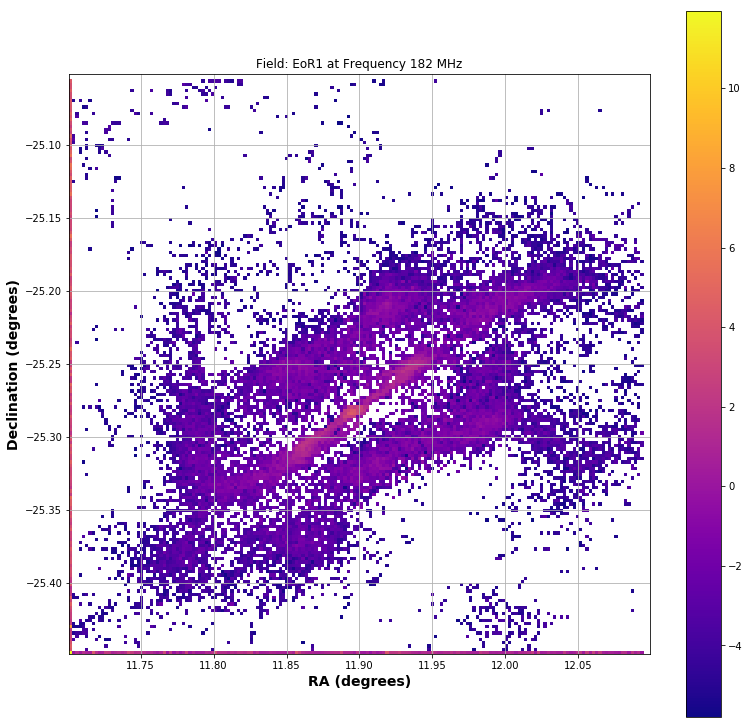

In [71]:
#dec as y, ra as x

#this makes the thing bigger!!
plt.figure(figsize=(13,13))

#imshow is a type of plot that shows the image (duh)
#took the log of the flux scale which made things happen
#interpolation made the pixels not fuzzy
#origin reoriented the y axis so it goes from 0 to 100 instead of 100 to 0
#cmap changed the colorbar so that the colors are sequentially dark-light in relation to flux
plt.imshow(np.transpose(np.log(pixels2)), interpolation = "nearest", origin = "lower", cmap = "plasma", 
           extent = [ra_pixel_centers[0], ra_pixel_centers[len(ra_pixel_centers)-1], 
           dec_pixel_centers[0], dec_pixel_centers[len(dec_pixel_centers)-1]])

#the x and y axis labels are not accurate right now but that's okay :)
plt.xlabel('RA (degrees)', 
           fontweight='bold', size=14)
plt.ylabel('Declination (degrees)', 
           fontweight='bold', size=14)
plt.title('Field: EoR1 at Frequency 182 MHz')

plt.colorbar()
plt.grid()
plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


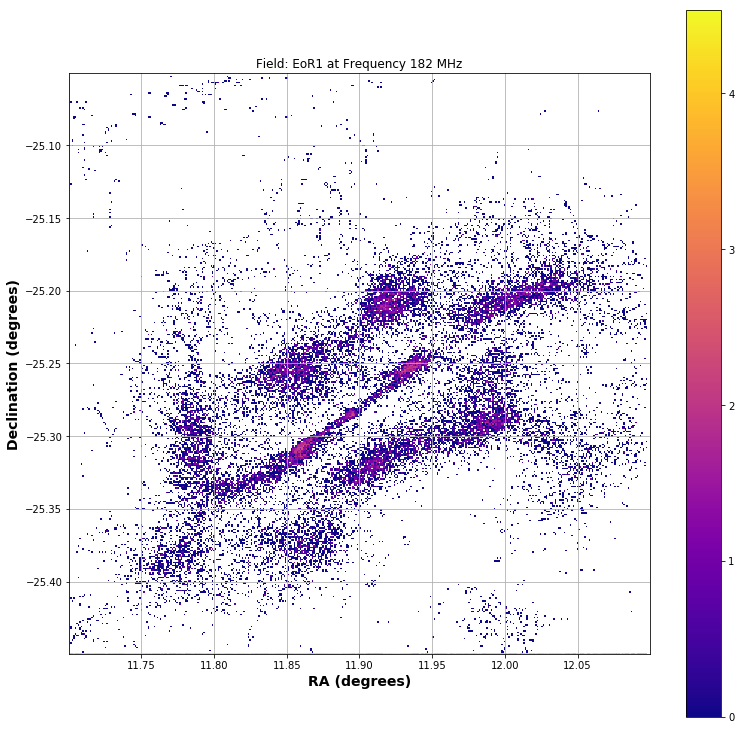

In [71]:
#this makes the thing bigger!!
plt.figure(figsize=(13,13))

#imshow is a type of plot that shows the image (duh)
#took the log of the flux scale which made things happen
#interpolation made the pixels not fuzzy
#origin reoriented the y axis so it goes from 0 to 100 instead of 100 to 0
#cmap changed the colorbar so that the colors are sequentially dark-light in relation to flux
plt.imshow(np.transpose(np.log(contributed_obs)), interpolation = "nearest", origin = "lower", cmap = "plasma", 
           extent = [ra_pixel_centers[0], ra_pixel_centers[len(ra_pixel_centers)-1], 
           dec_pixel_centers[0], dec_pixel_centers[len(dec_pixel_centers)-1]])

#the x and y axis labels are not accurate right now but that's okay :)
plt.xlabel('RA (degrees)', 
           fontweight='bold', size=14)
plt.ylabel('Declination (degrees)', 
           fontweight='bold', size=14)
plt.title('Field: EoR1 at Frequency 182 MHz')

plt.colorbar()
plt.grid()
plt.show()

In [14]:
[2,10,2]

[2, 10, 2]

In [18]:
print(*range(40,400,20))

40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380
